In [30]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [2]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [3]:
df = pd.read_csv("spam_or_not_spam.csv")

In [4]:
df.columns = ['text', 'label']

In [5]:
# 1 if spam
df.head()

,text,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


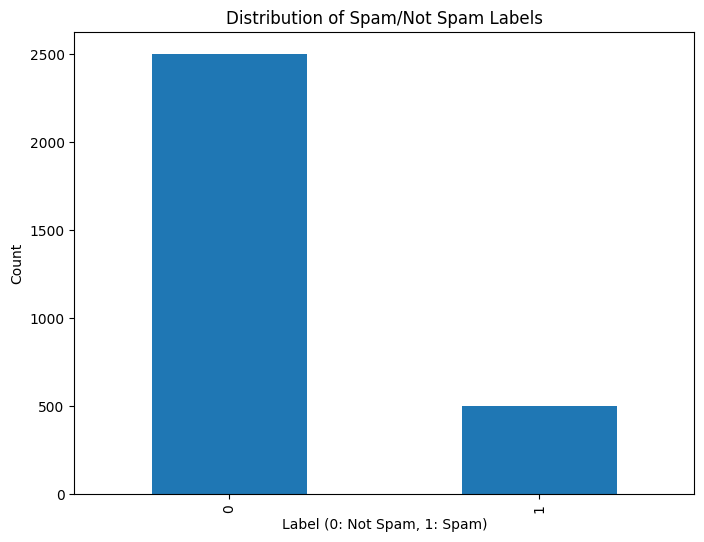

In [6]:
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Spam/Not Spam Labels')
plt.xlabel('Label (0: Not Spam, 1: Spam)')
plt.ylabel('Count')
plt.show()

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)

In [8]:
df['text_clean'] = df['text'].apply(clean_text)

In [9]:
df

,text,label,text_clean
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0,date wed number aug number number number numbe...
1,martin a posted tassos papadopoulos the greek ...,0,martin posted tasso papadopoulos greek sculpto...
2,man threatens explosion in moscow thursday aug...,0,man threatens explosion moscow thursday august...
3,klez the virus that won t die already the most...,0,klez virus die already prolific virus ever kle...
4,in adding cream to spaghetti carbonara which ...,0,adding cream spaghetti carbonara effect pasta ...
...,...,...,...
2995,abc s good morning america ranks it the NUMBE...,1,abc good morning america rank number christmas...
2996,hyperlink hyperlink hyperlink let mortgage le...,1,hyperlink hyperlink hyperlink let mortgage len...
2997,thank you for shopping with us gifts for all ...,1,thank shopping u gift occasion free gift numbe...
2998,the famous ebay marketing e course learn to s...,1,famous ebay marketing e course learn sell comp...


In [14]:
df['word_count'] = df['text_clean'].apply(lambda x: len(x.split()))
df['char_count'] = df['text_clean'].str.len()
df['word_density'] = df['char_count'] / df['word_count']

In [22]:
df_nspam = df[df['label'] == 0]
df_spam = df[df['label'] == 1]

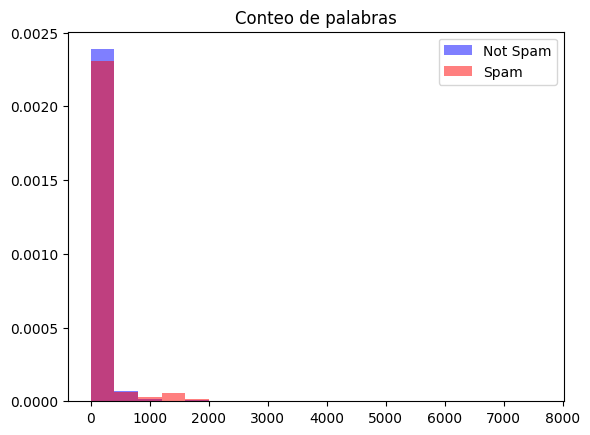

In [23]:
plt.figure()
plt.title('Conteo de palabras')
bins = np.linspace(np.min(df['word_count']), np.max(df['word_count']), 20)

plt.hist(df_nspam['word_count'],  label = 'Not Spam', bins = bins, color = 'blue', alpha = 0.5, density = True)
plt.hist(df_spam['word_count'],  label = 'Spam', bins = bins, color = 'red', alpha = 0.5, density = True)
plt.legend()
plt.show()

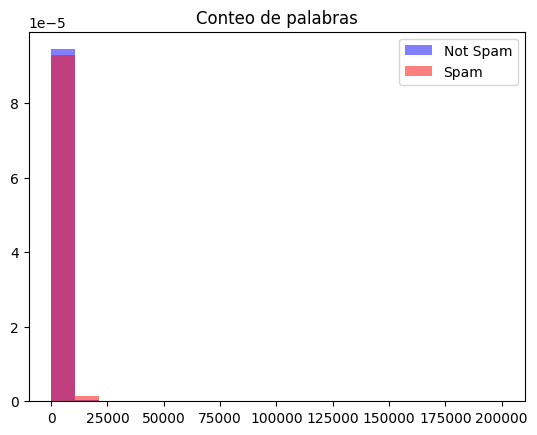

In [24]:
plt.figure()
plt.title('Conteo de palabras')
bins = np.linspace(np.min(df['char_count']), np.max(df['char_count']), 20)

plt.hist(df_nspam['char_count'],  label = 'Not Spam', bins = bins, color = 'blue', alpha = 0.5, density = True)
plt.hist(df_spam['char_count'],  label = 'Spam', bins = bins, color = 'red', alpha = 0.5, density = True)
plt.legend()
plt.show()

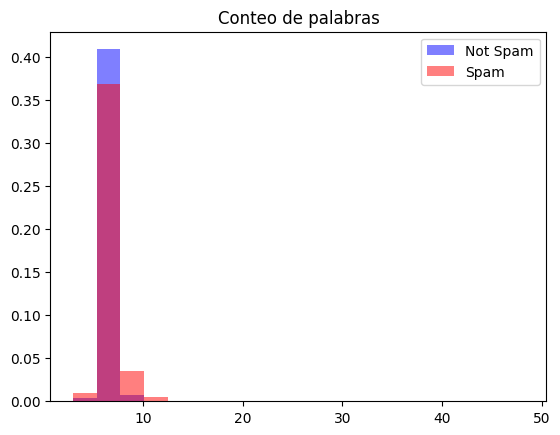

In [25]:
plt.figure()
plt.title('Conteo de palabras')
bins = np.linspace(np.min(df['word_density']), np.max(df['word_density']), 20)

plt.hist(df_nspam['word_density'],  label = 'Not Spam', bins = bins, color = 'blue', alpha = 0.5, density = True)
plt.hist(df_spam['word_density'],  label = 'Spam', bins = bins, color = 'red', alpha = 0.5, density = True)
plt.legend()
plt.show()

In [26]:
# Create Feature and Label sets
X = df['text_clean']
y = df['label']

# train test split (80% train - 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print('Training Data :', X_train.shape)
print('Testing Data : ', X_test.shape)

Training Data : (2100,)
Testing Data :  (900,)


In [28]:
tfidf_vect = TfidfVectorizer(analyzer='word')
xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [46]:
#Logistic Regression
lr = LogisticRegression()
lr.fit(xtrain_tfidf, y_train)
predictions = lr.predict(xtest_tfidf)

# Evaluate the model
lr_accuracy = metrics.accuracy_score(y_test, predictions)
print(f"Accuracy: {lr_accuracy}")

df_confusion = pd.DataFrame(metrics.confusion_matrix(y_test, predictions), index=['not spam','spam'], columns=['not_spam_pred','spam_pred'])
df_confusion

Accuracy: 0.9555555555555556


,not_spam_pred,spam_pred
not spam,757,0
spam,40,103


In [45]:
#Support Vector Machine
svm = SVC()
svm.fit(xtrain_tfidf, y_train)
svm_predictions = svm.predict(xtest_tfidf)

# Evaluate the model
svm_accuracy = metrics.accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")

df_svm_confusion = pd.DataFrame(metrics.confusion_matrix(y_test, svm_predictions), index=['not spam','spam'], columns=['not_spam_pred','spam_pred'])
df_svm_confusion


SVM Accuracy: 0.9822222222222222


,not_spam_pred,spam_pred
not spam,757,0
spam,16,127


In [41]:
#Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(xtrain_tfidf, y_train)
nb_predictions = nb.predict(xtest_tfidf)

# Evaluate the model
nb_accuracy = metrics.accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy}")

df_nb_confusion = pd.DataFrame(metrics.confusion_matrix(y_test, nb_predictions), index=['not spam','spam'], columns=['not_spam_pred','spam_pred'])
df_nb_confusion


Naive Bayes Accuracy: 0.8844444444444445


,not_spam_pred,spam_pred
not spam,757,0
spam,104,39


In [44]:
#Random Forest
rf = RandomForestClassifier()
rf.fit(xtrain_tfidf, y_train)
rf_predictions = rf.predict(xtest_tfidf)

# Evaluate the model
rf_accuracy = metrics.accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

df_rf_confusion = pd.DataFrame(metrics.confusion_matrix(y_test, rf_predictions), index=['not spam','spam'], columns=['not_spam_pred','spam_pred'])
df_rf_confusion


Random Forest Accuracy: 0.9822222222222222


,not_spam_pred,spam_pred
not spam,754,3
spam,13,130


In [47]:
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")
print(f"Naive Bayes Accuracy: {nb_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")

Logistic Regression Accuracy: 0.9555555555555556
SVM Accuracy: 0.9822222222222222
Naive Bayes Accuracy: 0.8844444444444445
Random Forest Accuracy: 0.9822222222222222
